# BATADAL - Familiarization Task

The BATtle of the Attack Detection ALgorithms (BATADAL) data is the hourly historical supervisory control and data acquisition (SCADA) operations of the C-Town water distribution system ([R. Taormina et al, 2018](http://dx.doi.org/10.1061/(ASCE)WR.1943-5452.0000969)).

The purpose of this familiarization task is to understand the properties and behaviours of the dataset(s). More specifically, to answer the following questions:

1. *What kind of signals are there?*
2. *Are the signals correlated? Do they show cyclic behaviour?*
3. *Is predicting the next value in a series easy or hard? (use any method from class)*

Visualize these types, the presence or absence of correlation, and the performance of prediction.

## Description of the datasets

Three BATADAL datasets ([R. Taormina et al, 2018](http://dx.doi.org/10.1061/(ASCE)WR.1943-5452.0000969)) are available:

1. *Training dataset 1:* A one-year long simulation data, does not contain any attacks, i.e., all te data pertains to C-Town normal operations.
2. *Training dataset 2:* Partially labelled data of around 6 months long and contains several attacks, some of which are approximately labelled.
3. *Test dataset:* A 3-months long dataset which contains several attacks but no labels. Supposed to be used to compare the performance of the algorithms. *Therefore the test dataset will not be used in this familiarization task.*

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import time, datetime
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from multiprocessing import Pool

## Visualization of the signals

We first have a glance at the columns of *training dataset 1* to get a premiliary idea of the data.

In [4]:
# Load dataset
dftrain1 = pd.read_csv('./data/BATADAL_dataset03.csv')

# Modify string date to timestamp
dftrain1.DATETIME = dftrain1.DATETIME.apply(lambda s: pd.to_datetime(s, format = '%d/%m/%y %H'))

In [5]:
# Check dataset
dftrain1.sample(n = 10)
dftrain1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8761 entries, 0 to 8760
Data columns (total 45 columns):
DATETIME    8761 non-null datetime64[ns]
L_T1        8761 non-null float64
L_T2        8761 non-null float64
L_T3        8761 non-null float64
L_T4        8761 non-null float64
L_T5        8761 non-null float64
L_T6        8761 non-null float64
L_T7        8761 non-null float64
F_PU1       8761 non-null float64
S_PU1       8761 non-null int64
F_PU2       8761 non-null float64
S_PU2       8761 non-null int64
F_PU3       8761 non-null int64
S_PU3       8761 non-null int64
F_PU4       8761 non-null float64
S_PU4       8761 non-null int64
F_PU5       8761 non-null int64
S_PU5       8761 non-null int64
F_PU6       8761 non-null float64
S_PU6       8761 non-null int64
F_PU7       8761 non-null float64
S_PU7       8761 non-null int64
F_PU8       8761 non-null float64
S_PU8       8761 non-null int64
F_PU9       8761 non-null int64
S_PU9       8761 non-null int64
F_PU10      8761 non-null 

According to [R. Taormina et al (2018)](http://dx.doi.org/10.1061/(ASCE)WR.1943-5452.0000969) we know that the dataset is an hourly record from the SCADA system, where the columns state for:

- *L_T #* : water level of a tank # [meter].
- *S_PU #* or *S_V #* : status of a pump # or a valve # [dmnl]. Binary signal.
- *F_PU #* or *F_V #* : flowrate of a pump # or a valve # [L/s].
- *P_J #* : inlet and outlet pressure for a junction # [meter].

We now make plots for each category of variables to see how the behaviours look like.

In [72]:
# a list of prefix to subset the columns
catPrefix = [[0, '^L', 'Water level of tank', 'meter'], 
             [1, '^F', 'Flowrate of pump/valve', 'L/s'], 
             [2, '^S', 'Status of pump/valve', 'dmnl'], 
             [3, '^P', 'Pressure of junction', 'meter']]

In [ ]:
# make subplot of each category/prefix of variables
fig, ax = plt.subplots(len(catPrefix), 1, figsize = (9, 12), sharex = True)
fig.subplots_adjust(hspace = 0.5)

for i, prefix, title, dim in catPrefix:
    ax[i, ].plot(dftrain1.filter(regex = prefix))
    ax[i, ].legend(dftrain1_sub.filter(regex = prefix).columns.to_list(), 
                   loc = 'upper center', bbox_to_anchor = (1.17, 1), ncol = 2)
    ax[i, ].set_title(title)
    ax[i, ].set_ylabel(dim)

ax[i, ].set_xlabel('Hour')
fig.align_ylabels()

It is very difficult to see when the whole one-year data is plotted. We then try to plot a subset of 5-days (randomly picked starting-date) to make the plot clearer to see.

In [107]:
# subset a data of time-length of 5 days
dftrain1_sub = dftrain1[300:300+24*5]

In [ ]:
# plot the variables
fig, ax = plt.subplots(len(catPrefix), 1, figsize = (9, 12), sharex = True)
fig.subplots_adjust(hspace = 0.5)

for i, prefix, title, dim in catPrefix:
    ax[i, ].plot(dftrain1_sub.filter(regex = prefix))
    ax[i, ].legend(dftrain1_sub.filter(regex = prefix).columns.to_list(), 
                   loc = 'upper center', bbox_to_anchor = (1.17, 1), ncol = 2)
    ax[i, ].set_title(title)
    ax[i, ].set_ylabel(dim)

ax[i, ].set_xlabel('Hour')
fig.align_ylabels()

Now the visuals are clearer to see. From the graph we can see clear cyclic behaviours in many variables, especially the pressure readings of junctions and flowrates of pumps/valves. There could also be cyclic behaviours in water levels of the tanks (clear results in tank 3 and 5), yet it is more difficult to tell.

## Correlations between signals

Based on the understanding of water distribution system, we know that correlations should exist in this data as the system is operated by control logic - for instance, per [R. Taormina et al (2018)](http://dx.doi.org/10.1061/(ASCE)WR.1943-5452.0000969) and the .INP file, in this system PLC1 controls pump PU1 and PU2 on the basis of tank T1 water level. Pump PU1 and PU2 situate in pumping station S1, where the inlet/outlet or suction/discharge pressure are monitored at junction J280 and J269 respectively.

We can therefore plot the following variables to see the correlation among them: L_T1, S_PU1, F_PU1, S_PU2, F_PU2, P_J280 and P_J269.

In [137]:
# a list of variables to subset from the dataframe
listCorr = [[0, 'L_T1', 'Water level of tank T1, L_T1', 'meter'], 
            [1, 'F_PU1', 'Flowrate of pump PU1, F_PU1', 'L/s'], 
            [2, 'S_PU1', 'Status of pump PU1, S_PU1', 'dmnl'], 
            [3, 'F_PU2', 'Flowrate of pump PU2, F_PU1', 'L/s'],
            [4, 'S_PU2', 'Status of pump PU2, S_PU2', 'dmnl'],
            [5, 'P_J280', 'Inlet pressure of pumping station for PU1/PU2/PU3, P_J280', 'meter'],
            [6, 'P_J269', 'Outlet pressure of pumping station for PU1/PU2/PU3, P_J269', 'meter']]

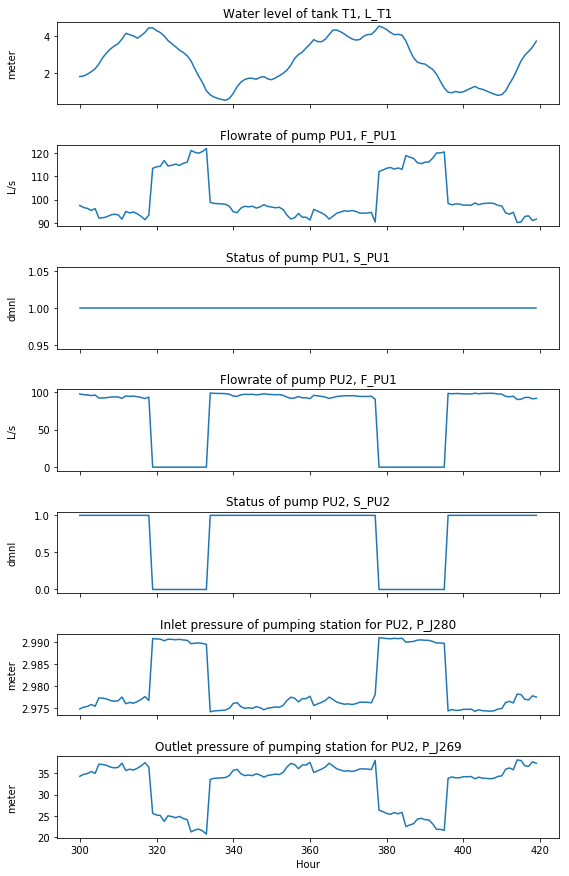

In [138]:
# plot the variables
fig, ax = plt.subplots(len(listCorr), 1, figsize = (9, 15), sharex = True)
fig.subplots_adjust(hspace = 0.5)

for i, variable, title, dim in listCorr:
    ax[i, ].plot(dftrain1_sub[variable])
    ax[i, ].set_title(title)
    ax[i, ].set_ylabel(dim)

ax[i, ].set_xlabel('Hour')
fig.align_ylabels()

Similarly, we can plot the variables that are related to water level of tank T3: L_T3, S_PU4, F_PU4, S_PU5, F_PU5, P_J300 and P_J256.

In [154]:
# a list of variables to subset from the dataframe
listCorr = [[0, 'L_T3', 'Water level of tank T3, L_T3', 'meter'], 
            [1, 'F_PU4', 'Flowrate of pump PU4, F_PU4', 'L/s'], 
            [2, 'S_PU4', 'Status of pump PU4, S_PU4', 'dmnl'], 
            [3, 'F_PU5', 'Flowrate of pump PU5, F_PU5', 'L/s'],
            [4, 'S_PU5', 'Status of pump PU5, S_PU5', 'dmnl'],
            [5, 'P_J300', 'Inlet pressure of pumping station for PU4/PU5/PU6/PU7, P_J300', 'meter'],
            [6, 'P_J256', 'Outlet pressure of pumping station for PU4/PU5/PU6/PU7, P_J256', 'meter']]

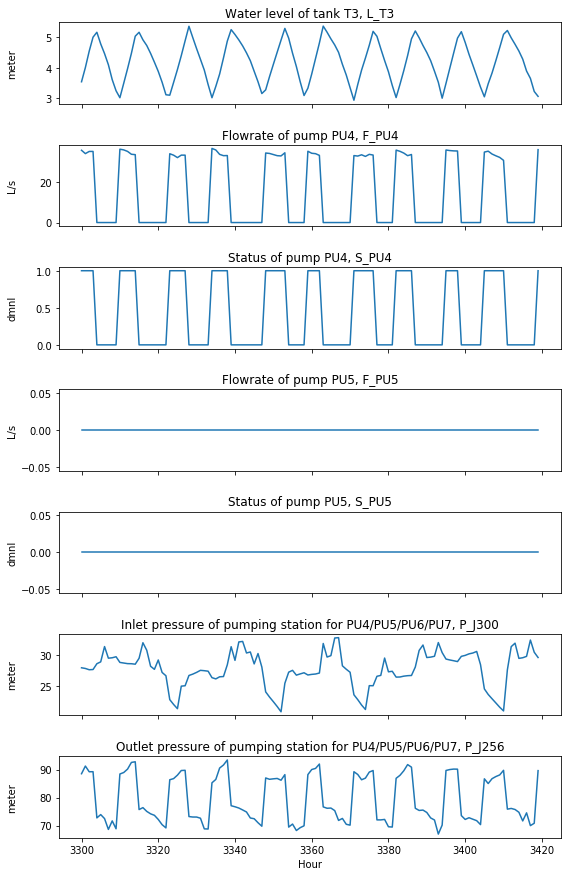

In [155]:
# plot the variables
fig, ax = plt.subplots(len(listCorr), 1, figsize = (9, 15), sharex = True)
fig.subplots_adjust(hspace = 0.5)

for i, variable, title, dim in listCorr:
    ax[i, ].plot(dftrain1_sub[variable])
    ax[i, ].set_title(title)
    ax[i, ].set_ylabel(dim)

ax[i, ].set_xlabel('Hour')
fig.align_ylabels()

The correlation with those of pressure readings at junction J300 and J356 is less obvious because the readings are also related with other pumps PU7 and PU8. Yet, from this graph, we can see clearing that when pump PU5 is set OFF throughout the time, water level at tank T3 has a very obvious correlation with flowrate of pump PU4.

## Predicting the next value

Apply basic machine learning techniques combined with time slicing / sliding windows.